# Image Classification Model Deployment
Muhammad Khairul Rizki Ramadhan\
https://github.com/khairulrizki

## Mempersiapkan Dataset

In [1]:
#Sebelum memasukkan Dataset, kita import library yang akan kita gunakan dahulu
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import files
#Upload Kaggle API Key
files.upload()

Saving kaggle.json to kaggle (6).json


{'kaggle (6).json': b'{"username":"khairulrizkii","key":"67685a247c7234849e224e2b2db3cc2d"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
!kaggle datasets download -d grassknoted/asl-alphabet

mkdir: cannot create directory ‘/root/.kaggle’: File exists
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import os, zipfile
zipPath = '/content/asl-alphabet.zip'
zipFile = zipfile.ZipFile(zipPath, 'r')
zipFile.extractall('../content/dataset/')
zipFile.close()

In [5]:

dataset = "/content/dataset/asl_alphabet_train/asl_alphabet_train"

In [6]:
#Mempersiapkan data train
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    fill_mode = 'nearest',
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training'
)

#Mempersiapka data validation
val_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    validation_split = 0.2
)

val_generator = val_datagen.flow_from_directory(
    dataset,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


## Membuat Model

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
mobilenet = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in mobilenet.layers:
    layer.trainable = False

In [10]:
model = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(padding='same'),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(29, activation='softmax'),
])

In [11]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [12]:
#Callback

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>=0.80 and logs.get('val_accuracy')>=0.80):
            self.model.stop_training = True
callbacks=myCallback()

In [13]:
Hist = model.fit(train_generator,
                epochs=200,
                validation_data=val_generator,
                callbacks=[callbacks])

Epoch 1/200
2175/2175 [==============================] - 136s 59ms/step - loss: 0.5403 - accuracy: 0.8419 - val_loss: 1.1114 - val_accuracy: 0.7410
Epoch 2/200
2175/2175 [==============================] - 125s 57ms/step - loss: 0.1441 - accuracy: 0.9619 - val_loss: 0.9959 - val_accuracy: 0.8089


## Evaluasi Model

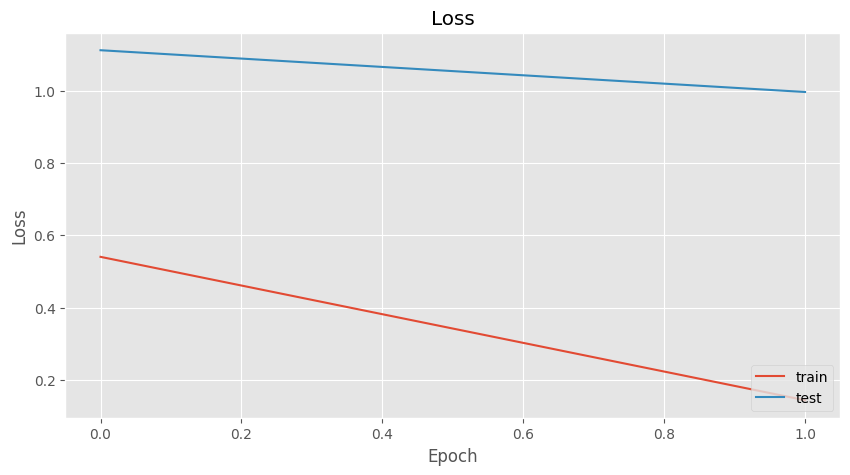

In [14]:
#Model Loss
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(Hist.history["loss"], label="training")
plt.plot(Hist.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'test'], loc='lower right')
plt.show()

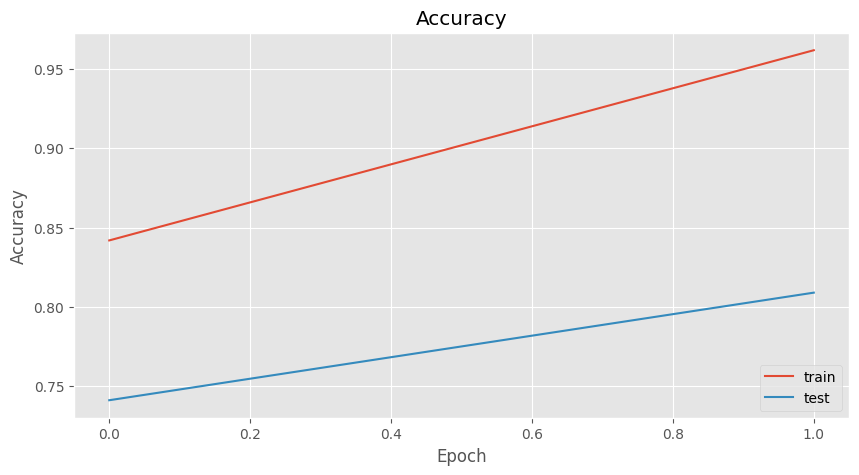

In [15]:
#Model Accuracy
plt.figure(figsize=(10, 5))
plt.plot(Hist.history["accuracy"], label="training")
plt.plot(Hist.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'test'], loc='lower right')
plt.show()

## Mengubah Model Menjadi TFLite

In [16]:
import pathlib
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('ISLModel.tflite')
tflite_model_file.write_bytes(tflite_model)

11904404